In [1]:
import xarray as xr 
import numpy as np 
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

BASE_DIR = f"/scratch/users/robcking/icon_base_3d.nc"

icon_ds = xr.open_dataset(BASE_DIR)
icon_ds

<xarray.Dataset>
Dimensions:  (time: 53, lon: 512, lat: 256, plev: 11)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-01T06:00:00 ... 2023-01-13
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
  * plev     (plev) float64 1e+03 5e+03 1e+04 2.5e+04 ... 9.5e+04 9.75e+04 1e+05
Data variables:
    u        (time, plev, lat, lon) float32 ...
    v        (time, plev, lat, lon) float32 ...
    temp     (time, plev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    source:       git@gitlab.dkrz.de:icon/icon-nwp.git@19fdc9a13604990f224d94...
    institution:  Max Planck Institute for Meteorology/Deutscher Wetterdienst
    title:        ICON simulation
    history:      Wed Nov 27 21:27:25 2024: ncrcat base_N128_day_01.nc base_N...
    references:   see MPIM/DWD publications
    comment:      Claudia Stephan (m300685) on l30733 (Linux 4.18.0-513.24.1....
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...
    NCO:          netCDF Operators version 4.8.0 (Homepage = http://nco.sf.ne...

In [20]:
tropics = icon_ds.sel(lat=slice(-15,15,-1)) # indexed backwards for some reason 
tropics

<xarray.Dataset> Size: 38MB
Dimensions:        (time: 148, lon: 512, lat: 42)
Coordinates:
  * time           (time) datetime64[ns] 1kB 2023-01-01 ... 2023-02-06
  * lon            (lon) float64 4kB 0.0 0.7031 1.406 ... 357.9 358.6 359.3
  * lat            (lat) float64 336B -14.39 -13.68 -12.98 ... 12.98 13.68 14.39
Data variables:
    tot_prec       (time, lat, lon) float32 13MB ...
    tot_prec_rate  (time, lat, lon) float32 13MB ...
    cloudtop       (time, lat, lon) float32 13MB ...
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    source:       git@gitlab.dkrz.de:icon/icon-nwp.git@19fdc9a13604990f224d94...
    institution:  Max Planck Institute for Meteorology/Deutscher Wetterdienst
    title:        ICON simulation
    history:      Fri Oct 18 13:15:01 2024: ncrcat coarse_N128_atm_2d_ML_2023...
    references:   see MPIM/DWD publications
    comment:      Claudia Stephan (m300685) on l40043 (Linux 4.18.0-477.27.1....
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...
    NCO:          netCDF Operators version 4.8.0 (Homepage = http://nco.sf.ne...

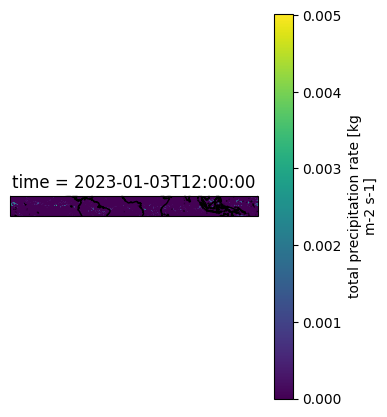

In [22]:
fig = plt.figure(figsize=(4,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
tropics.tot_prec_rate.isel(time=10).plot.pcolormesh(ax=ax, x = 'lon',y='lat')
ax.coastlines()

In [35]:
tropics.tot_prec_rate.shape # time, lat, lon 

(148, 42, 512)

In [39]:
import wavenumber_frequency_functions as wf 
spd = 4
segsize = int(len(tropics.time)/spd)
noverlap = min(segsize,60*spd)

precip_power = wf.spacetime_power(tropics.tot_prec_rate,segsize=segsize,noverlap=noverlap,spd=spd,latitude_bounds=(-15,15),dosymmetries=True,rmvLowFrq=False)
precip_power_avg = precip_power.mean(dim='component')

precip_power.loc[{'frequency':0}] = np.nan # remove power at zero, we detrended so this signal should be removed

background = wf.smooth_wavefreq(precip_power_avg,kern=wf.simple_smooth_kernel(),nsmooth=50,freq_name='frequency')


precip_power_sym = precip_power.isel(component=0)
precip_power_asym = precip_power.isel(component=1)

wk_sym = precip_power_sym/background
wk_asym = precip_power_asym/background

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 148, 'lat': 42, 'lon': 512})
DEBUG:root:[spacetime_power] data shape after removing low frequencies: (148, 42, 512)
DEBUG:root:[spacetime_power] variance of data before windowing: 2.2705972213543646e-08
DEBUG:root:[spacetime_power] x_win shape is (1, 42, 512, 148)
INFO:root:No missing, so use simplest segment detrend.
DEBUG:root:[spacetime_power] x_win variance of segments: [1.9090267e-08]
DEBUG:root:[spacetime_power] x_wintap variance of segments: [1.78441414e-08]
DEBUG:root:[Hayashi] nDayWin: 37, spd: 4
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (1, 42, 512, 148) || Input dtype: varfft.dtype = dtype('complex128')
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) datetime64[ns] 8B 2023-02-06
  * lat         (lat) float64 336B -14.39 -13.68 -12.98 ... 12.98 13.68 14.39
  * wavenumber  (wavenumber) float64 4kB 0.0 1.0 2.0 3.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency  

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f1cfa40de20>


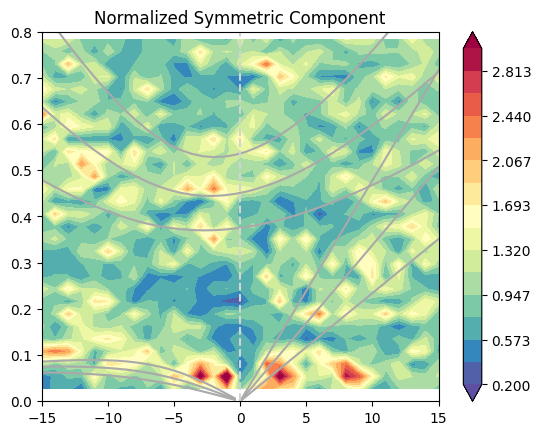

In [33]:
frequency_bounds = [0.,0.8]
swfreq,swwn = wf.genDispersionCurves()
swf = np.where(swfreq == 1e20, np.nan, swfreq)
swk = np.where(swwn == 1e20, np.nan, swwn)

fig, ax = plt.subplots()
c = 'darkgray' # COLOR FOR DISPERSION LINES/LABELS
z = wk_sym.transpose().sel(frequency=slice(*frequency_bounds), wavenumber=slice(-15,15))
z.loc[{'frequency':0}] = np.nan
kmesh0, vmesh0 = np.meshgrid(z['wavenumber'], z['frequency'])
img = ax.contourf(kmesh0, vmesh0, z, levels=np.linspace(0.2, 3.0, 16), cmap='Spectral_r',  extend='both')
for ii in range(3,6):
    ax.plot(swk[ii, 0,:], swf[ii,0,:], color=c)
    ax.plot(swk[ii, 1,:], swf[ii,1,:], color=c)
    ax.plot(swk[ii, 2,:], swf[ii,2,:], color=c)
ax.axvline(0, linestyle='dashed', color='lightgray')
ax.set_xlim([-15,15])
ax.set_ylim(frequency_bounds)    
ax.set_title("Normalized Symmetric Component")
fig.colorbar(img)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f1cb4be12b0>


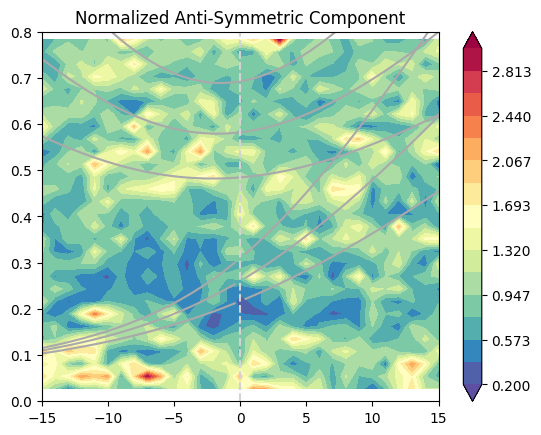

In [40]:
frequency_bounds = [0.,0.8]
swfreq,swwn = wf.genDispersionCurves()
swf = np.where(swfreq == 1e20, np.nan, swfreq)
swk = np.where(swwn == 1e20, np.nan, swwn)

fig, ax = plt.subplots()
c = 'darkgray' # COLOR FOR DISPERSION LINES/LABELS
z = wk_asym.transpose().sel(frequency=slice(*frequency_bounds), wavenumber=slice(-15,15))
z.loc[{'frequency':0}] = np.nan
kmesh0, vmesh0 = np.meshgrid(z['wavenumber'], z['frequency'])
img = ax.contourf(kmesh0, vmesh0, z, levels=np.linspace(0.2, 3.0, 16), cmap='Spectral_r',  extend='both')
for ii in range(0,3):
    ax.plot(swk[ii, 0,:], swf[ii,0,:], color=c)
    ax.plot(swk[ii, 1,:], swf[ii,1,:], color=c)
    ax.plot(swk[ii, 2,:], swf[ii,2,:], color=c)
ax.axvline(0, linestyle='dashed', color='lightgray')
ax.set_xlim([-15,15])
ax.set_ylim(frequency_bounds)    
ax.set_title("Normalized Anti-Symmetric Component")
fig.colorbar(img)